<a href="https://colab.research.google.com/github/syedshubha/QNET25_Shubha/blob/main/DenseErrorGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip

In [2]:
from qutip import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

from scipy.optimize import minimize
from scipy.linalg import logm, sqrtm
import warnings

In [3]:
zero = basis(2, 0)
one = basis(2, 1)

bell_state = (tensor(zero, zero) + tensor(one, one)).unit()
I = qeye(2)
rho = ket2dm(bell_state)  # Convert to density matrix

In [4]:
def von_neumann_entropy(rho):
    eigenvalues = rho.eigenenergies()
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    eigenvalues = eigenvalues[eigenvalues > 0]  # Ignore zero eigenvalues
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    return -np.sum(eigenvalues * np.log2(eigenvalues))

In [5]:
# Quantum Mutual Information
def quantum_mutual_information(rho):
    rho_A = rho.ptrace(0)  # Partial trace over B
    rho_B = rho.ptrace(1)  # Partial trace over A
    return von_neumann_entropy(rho_A) + von_neumann_entropy(rho_B) - von_neumann_entropy(rho)

# Classical Mutual Information
def classical_mutual_information(rho):
    rho_A = rho.ptrace(0)  # Partial trace over B
    rho_B = rho.ptrace(1)  # Partial trace over A
    def classical_corr(theta_phi):
        cond_entropy_B = 0
        theta, phi = theta_phi
        # Define measurement operator directly in QuTiP
        proj_0 = Qobj([[np.cos(theta / 2) ** 2, np.cos(theta / 2) * np.sin(theta / 2) * np.exp(-1j * phi)],
                       [np.cos(theta / 2) * np.sin(theta / 2) * np.exp(1j * phi), np.sin(theta / 2)**2]])
        proj_1 = Qobj([[np.sin(theta / 2) ** 2, -np.cos(theta / 2) * np.sin(theta / 2) * np.exp(-1j * phi)],
                       [-np.cos(theta / 2) * np.sin(theta / 2) * np.exp(1j * phi), np.cos(theta / 2)**2]])

        # Extend projectors to two-qubit space
        proj_0 = tensor(proj_0, qeye(2))
        proj_1 = tensor(proj_1, qeye(2))

        for proj in [proj_0, proj_1]:
            p_k = (proj * rho * proj.dag()).tr()
            if p_k > 1e-10:
                rho_post = (proj * rho * proj.dag()) / p_k
                rho_B_k = rho_post.ptrace(1)  # Partial trace over first qubit
                cond_entropy_B += p_k * von_neumann_entropy(rho_B_k)

        return -(von_neumann_entropy(rho_A) - cond_entropy_B)  # Negative for minimization
    result = minimize(classical_corr, [0, 0], bounds=[(0, np.pi), (0, 2 * np.pi)], method='Nelder-Mead')
    return -result.fun
# Quantum Discord
def quantum_discord(rho):
    return quantum_mutual_information(rho) - classical_mutual_information(rho)

In [6]:
# Concurrence for two-qubit state
def concurrence(rho):
    Y = Qobj([[0, -1j], [1j, 0]])  # Pauli Y
    R = rho * tensor(Y, Y) * rho.conj() * tensor(Y, Y)
    eigenvalues = np.sqrt(np.real(np.sort(R.eigenenergies())[::-1]))
    return max(0, eigenvalues[0] - sum(eigenvalues[1:]))

# Entanglement of Formation
def entanglement_of_formation(rho):
    C = concurrence(rho)
    if C == 0:
        return 0
    h = lambda x: -x * np.log2(x) - (1 - x) * np.log2(1 - x) if x > 0 else 0
    return h((1 + np.sqrt(1 - C**2)) / 2)

In [7]:
# Channel
def evolve(rho,lst):
  DM = 0*rho
  for T in lst:
    DM = T*rho*T.dag() + DM
  return DM

In [8]:
def noise_channel(rho, p, q):
    I = qeye(2)
    # Amplitude damping operators
    E0_amp = Qobj([[1, 0], [0, np.sqrt(1 - p)]])
    E1_amp = Qobj([[0, np.sqrt(p)], [0, 0]])
    # Phase damping operators
    E0_phase = Qobj([[np.sqrt(q), 0], [0, 0]])
    E1_phase = Qobj([[0, 0], [0, np.sqrt(q)]])
    E2_phase = Qobj([[np.sqrt(1-q), 0], [0, np.sqrt(1-q)]])

    # Apply amplitude damping on the first qubit
    K0_amp = tensor(E0_amp,I)
    K1_amp = tensor(E1_amp,I)

    # Apply phase damping on the first qubit
    K0_phase = tensor(I,E0_phase)
    K1_phase = tensor(I,E1_phase)
    K2_phase = tensor(I,E2_phase)


    #Extending for two qubit systems
    AD = [K0_amp, K1_amp]
    PD = [K0_phase, K1_phase, K2_phase]

    # Evolve the channel
    rho_after_amp = evolve(rho, AD)
    rho_final1 = evolve(rho_after_amp, PD)

    rho_after_phase = evolve(rho, PD)
    rho_final2= evolve(rho_after_phase, AD)

    rho_final = (rho_final1 + rho_final2)/2
    return rho_final

In [9]:
p = np.linspace(0.01, 1, 100)
q = np.linspace(0.1, 1, 10)
rho = ket2dm(bell_state)

discord_list = [[] for i in range(len(q))]
eof_list = [[] for i in range(len(q))]
fid_list = [[] for i in range(len(q))]

for i in range(len(q)):
  for j in range(len(p)):
    rho_final = noise_channel(rho, p[j], q[i])
    discord = quantum_discord(rho_final)
    eof = entanglement_of_formation(rho_final)
    fid = metrics.fidelity(rho, rho_final)
    fid_list[i].append(fid**2)
    discord_list[i].append(discord)
    eof_list[i].append(eof)
colors = plt.cm.tab20(np.linspace(0, 1, 10))

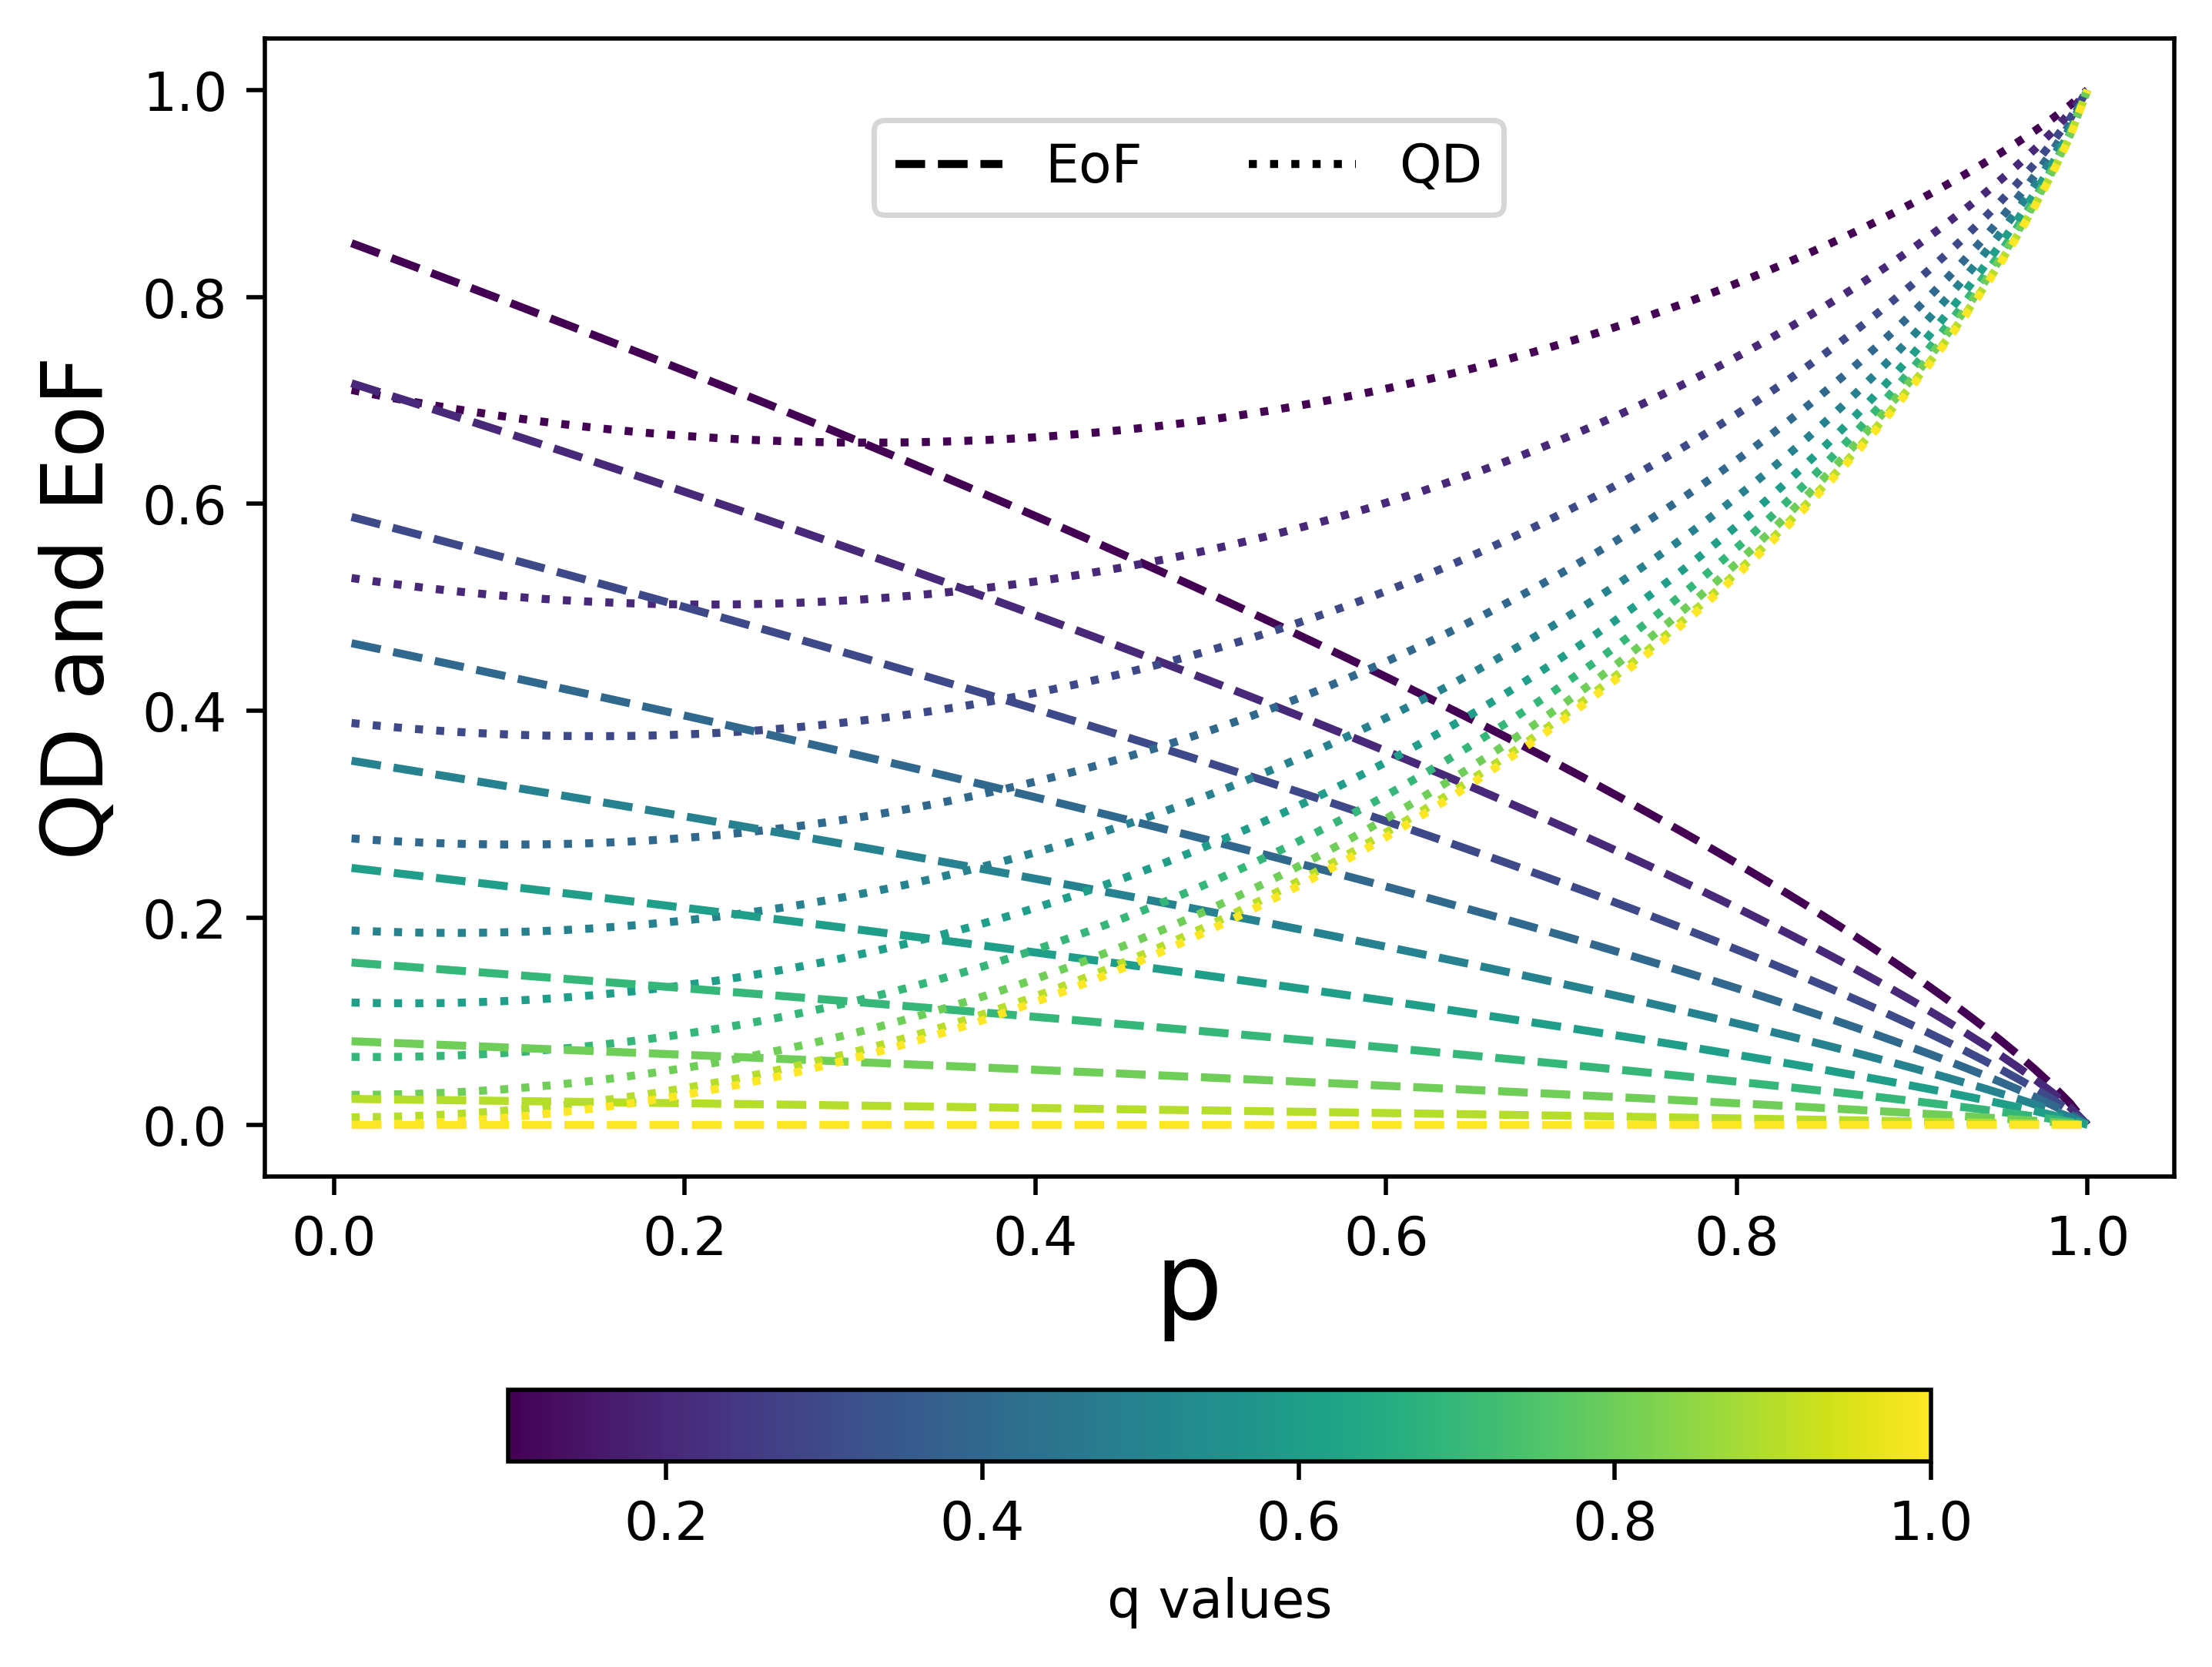

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

# Create figure and axis
fig, ax = plt.subplots(dpi=500)

# Normalize q values for color mapping
norm = mcolors.Normalize(vmin=min(q), vmax=max(q))
cmap = cm.viridis  # Choose a colormap

# Plot for Fidelity and EoF
for i in range(10):
    color = cmap(norm(q[i]))
    ax.plot(p, discord_list[i], linestyle=':', color=color)
    ax.plot(p, eof_list[i], linestyle='--', color=color)

ax.set_ylabel('QD and EoF', fontsize=16)

# Create a separate legend for line styles (Reduce gap)
eof_legend = mlines.Line2D([], [], color='black', linestyle='--', label='EoF')
qd_legend = mlines.Line2D([], [], color='black', linestyle=':', label='QD')

fig.legend(handles=[eof_legend, qd_legend], loc='upper center', bbox_to_anchor=(0.5, 0.85), ncol=2, fontsize=10)  # Reduced further

# Add a colorbar **below the legend, reducing the gap**
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)  # Fixed `ax`

fig.supxlabel('p', fontsize=20, y=0.175)  # Adjust y-position to avoid large gaps
cbar.set_label('q values', labelpad=5)

plt.savefig('QDEoF.png', bbox_inches='tight')
plt.show()


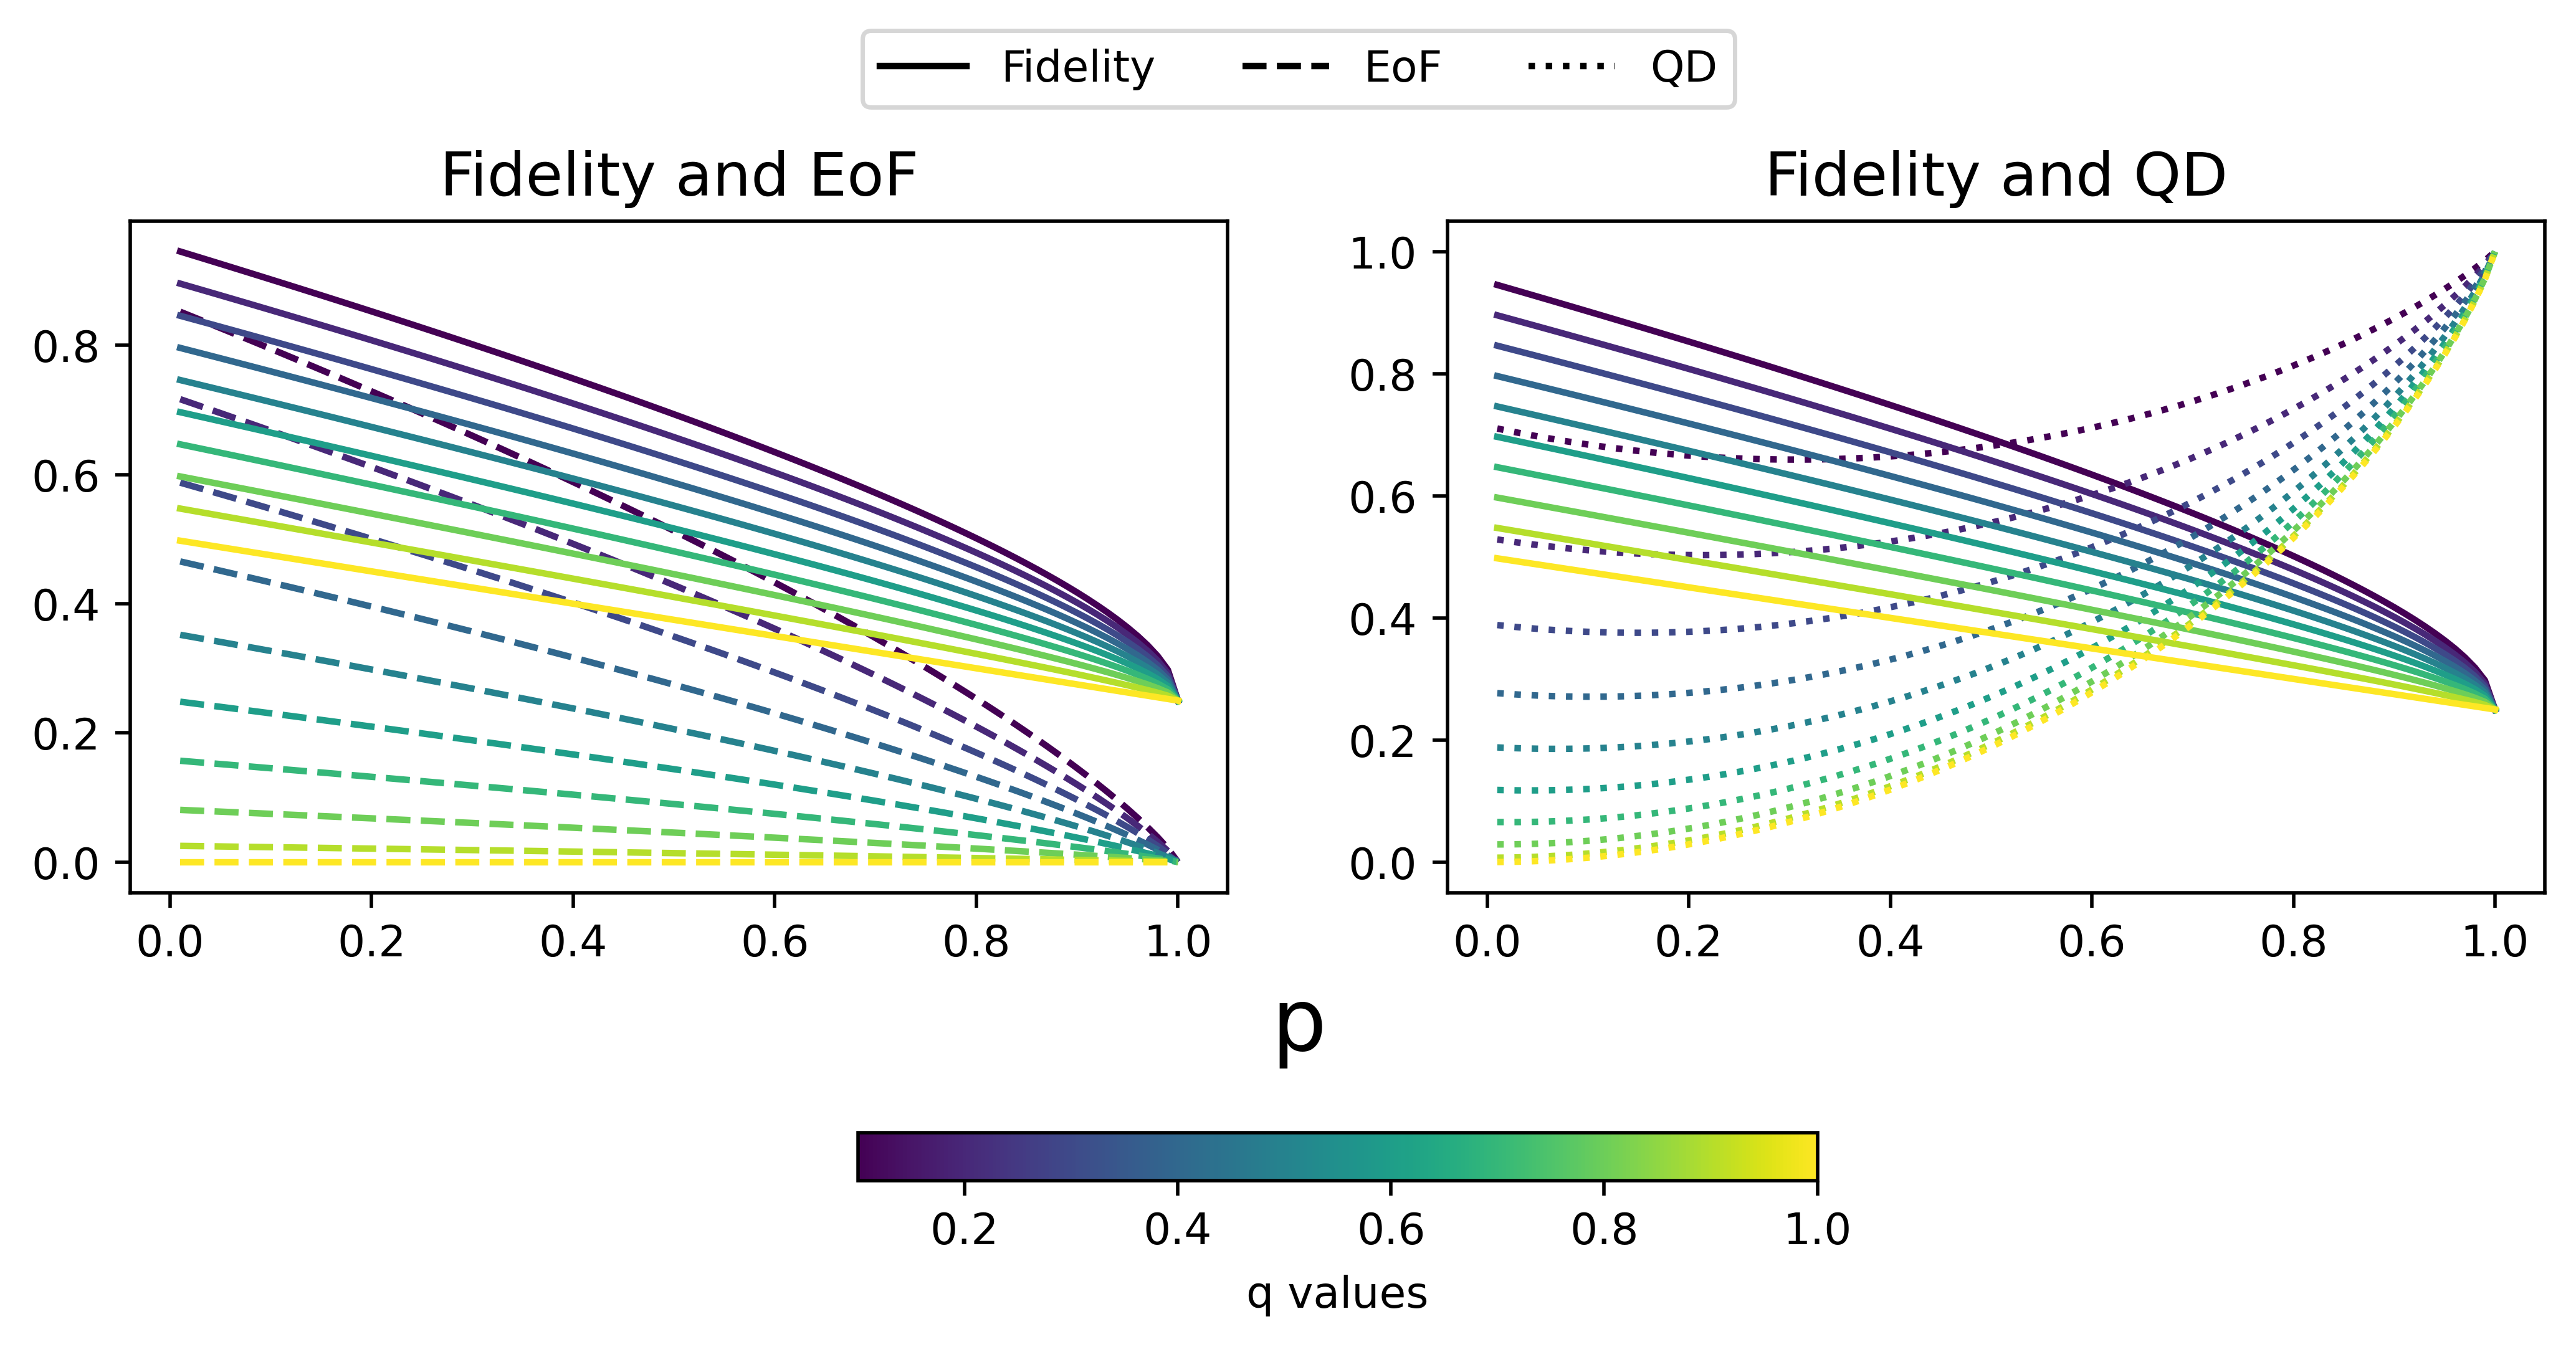

In [12]:
fig, axes = plt.subplots(1, 2, dpi=500, figsize=(10, 4))

# Normalize q values for color mapping
norm = mcolors.Normalize(vmin=min(q), vmax=max(q))
cmap = cm.viridis  # Choose a colormap

# Plot for Fidelity and EoF
for i in range(10):
    color = cmap(norm(q[i]))
    axes[0].plot(p, eof_list[i], linestyle='--', color=color)
    axes[0].plot(p, fid_list[i], linestyle='-', color=color)

# Plot for Fidelity and QD
for i in range(10):
    color = cmap(norm(q[i]))
    axes[1].plot(p, discord_list[i], linestyle=':', color=color)
    axes[1].plot(p, fid_list[i], linestyle='-', color=color)

axes[0].set_title('Fidelity and EoF', fontsize=14)
axes[1].set_title('Fidelity and QD', fontsize=14)

# Create a separate legend for line styles (Reduce gap)
fid_legend = mlines.Line2D([], [], color='black', linestyle='-', label='Fidelity')
eof_legend = mlines.Line2D([], [], color='black', linestyle='--', label='EoF')
qd_legend = mlines.Line2D([], [], color='black', linestyle=':', label='QD')

fig.legend(handles=[fid_legend, eof_legend, qd_legend], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=10)  # Reduced gap

# Add a colorbar **below the legend, reducing the gap**
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)  # Move it lower
fig.supxlabel('p', fontsize=20, y=0.2)  # Adjust y-position to avoid large gaps

cbar.set_label('q values', labelpad=5)


plt.savefig('Fid.png', bbox_inches='tight')
plt.show()
